<a href="https://colab.research.google.com/github/subham-28/PINN-EV-Battery-Prognostics/blob/main/Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upgrading the Physics Equation

Successfully loaded 168 discharge cycles.
   Cycle  Capacity
0      2  1.856487
1      4  1.846327
2      6  1.835349
3      8  1.835263
4     10  1.834646


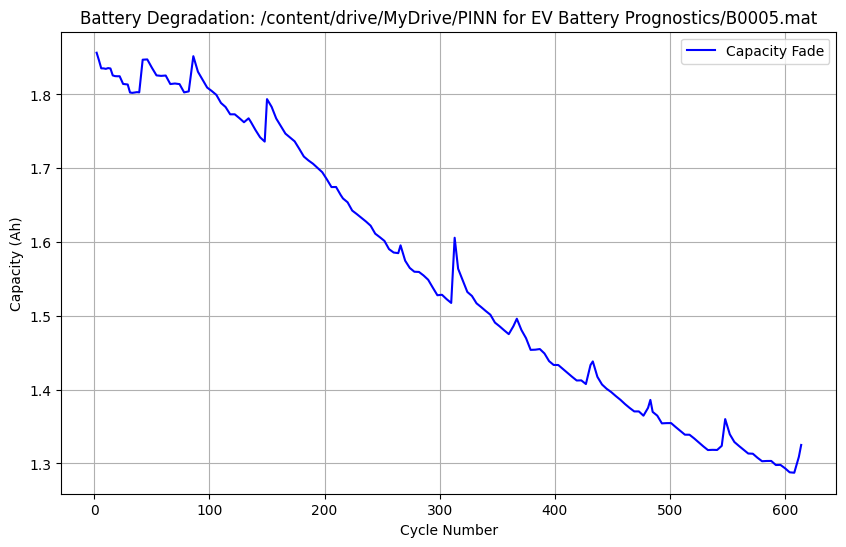

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_nasa_data(mat_file_path):
    data = scipy.io.loadmat(mat_file_path)
    filename = mat_file_path.split('/')[-1].split('.')[0]
    batch = data[filename]
    cycles = batch[0][0]['cycle'][0]

    cycle_numbers = []
    capacities = []

    for i, cycle in enumerate(cycles):
        cycle_type = cycle['type'][0]

        if cycle_type == 'discharge':
            try:
                capacity = cycle['data'][0][0]['Capacity'][0][0]

                cycle_numbers.append(i + 1) # Cycle count
                capacities.append(capacity) # Capacity in Amp-hours (Ah)
            except:
                pass

    df = pd.DataFrame({
        'Cycle': cycle_numbers,
        'Capacity': capacities
    })

    return df

filename = '/content/drive/MyDrive/PINN for EV Battery Prognostics/B0005.mat'

try:
    df_battery = load_nasa_data(filename)

    print(f"Successfully loaded {len(df_battery)} discharge cycles.")
    print(df_battery.head())

    # --- PLOT TO VERIFY ---
    plt.figure(figsize=(10, 6))
    plt.plot(df_battery['Cycle'], df_battery['Capacity'], 'b-', label='Capacity Fade')
    plt.xlabel('Cycle Number')
    plt.ylabel('Capacity (Ah)')
    plt.title(f'Battery Degradation: {filename}')
    plt.grid(True)
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find {filename}. Please download the dataset and place it in this folder.")

In [ ]:
df_battery.describe()

,Cycle,Capacity
count,168.000000,168.000000
mean,294.000000,1.572502
std,184.947314,0.190413
min,2.000000,1.287453
25%,133.000000,1.390021
50%,292.000000,1.557085
75%,454.000000,1.769163
max,614.000000,1.856487


In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
train_ratio=0.5
train_size=int(len(df_battery)*train_ratio)

In [ ]:
# normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_array = scaler.fit_transform(df_battery[['Capacity', 'Cycle']])

df_battery_scaled = pd.DataFrame(
    scaled_array,
    columns=['Capacity', 'Cycle'],
    index=df_battery.index   # keeps original index
)

In [ ]:
df_battery_scaled.describe()

,Capacity,Cycle
count,168.000000,168.000000
mean,0.500935,0.477124
std,0.334624,0.302201
min,0.000000,0.000000
25%,0.180250,0.214052
50%,0.473843,0.473856
75%,0.846539,0.738562
max,1.000000,1.000000


In [ ]:
df_battery_scaled.head()

,Capacity,Cycle
0,1.000000,0.000000
1,0.982145,0.003268
2,0.962852,0.006536
3,0.962700,0.009804
4,0.961616,0.013072


In [ ]:
train_data=df_battery_scaled.iloc[:train_size]
test_data=df_battery_scaled.iloc[train_size:]

In [ ]:
t_train_np=train_data['Cycle'].values.reshape(-1,1)
t_test_np=test_data['Cycle'].values.reshape(-1,1)

c_train_np=train_data['Capacity'].values.reshape(-1,1)
c_test_np=test_data['Capacity'].values.reshape(-1,1)

In [ ]:
# converting to tensorflow tensors to feed to nn
t_train_tf=tf.convert_to_tensor(t_train_np, dtype=tf.float32)
t_test_tf=tf.convert_to_tensor(t_test_np, dtype=tf.float32)

c_train_tf=tf.convert_to_tensor(c_train_np, dtype=tf.float32)
c_test_tf=tf.convert_to_tensor(c_test_np, dtype=tf.float32)

In [ ]:
print(f"Data Prepared for TensorFlow:")
print(f"Training Samples: {t_train_tf.shape[0]} (First {train_ratio*100}% of life)")
print(f"Testing Samples:  {t_test_tf.shape[0]} (Remaining {(1-train_ratio)*100}%)")

Data Prepared for TensorFlow:
Training Samples: 84 (First 50.0% of life)
Testing Samples:  84 (Remaining 50.0%)


 The Math (Differential Equation): Power Law

$$
\frac{dC}{dt} = -\alpha \cdot C(t)^β
$$
or
$$
\frac{dC}{dt} + \alpha \cdot C(t)^β = 0
$$


Where:
- $C(t)$: The current capacity (the size of the bucket right now)
- $\frac{dC}{dt}$: The rate of change (how fast the capacity is dropping)
- $\alpha$: The decay rate (positive constant; the minus sign indicates decay)
- $\beta$: Controls the curvature of the curve

In [ ]:
class PINNModel(tf.keras.Model):
  def __init__(self):
    super(PINNModel, self).__init__()

    #building hidden layers
    self.hidden1=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden2=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden3=tf.keras.layers.Dense(32,activation='tanh')

    #buidling output layer
    self.out=tf.keras.layers.Dense(1,activation=None)

    #starting the initial value of \alpha as 0.01 which is to be trained
    self.alpha=tf.Variable(1.0, dtype=tf.float32, trainable=True)
    self.beta=tf.Variable(2.0, dtype=tf.float32, trainable=True)


  def call(self,t):
    #this func return the capacity predicted for a time

    x=self.hidden1(t)
    x=self.hidden2(x)
    x=self.hidden3(x)
    x=self.out(x)
    return x

  def physics_loss(self,t):

    with tf.GradientTape() as tape:
      tape.watch(t)
      c_pred=self.call(t) #capacity predicted

    #finding dc/dt
    dc_dt=tape.gradient(c_pred,t)

    a = tf.abs(self.alpha)
    b = tf.abs(self.beta)

    residue=dc_dt+(a*tf.pow(c_pred,b))

    #finding how wrong are we from MSE
    loss_f=tf.reduce_mean(tf.square(residue))
    return loss_f

In [ ]:
#initializing model
pinn = PINNModel()

In [ ]:
#just for testing
_ = pinn(t_train_tf[:5])

In [ ]:
print(f"Power Law Model Initialized.")
print(f"Start Alpha: {pinn.alpha.numpy()}, Start Beta: {pinn.beta.numpy()}")

Power Law Model Initialized.
Start Alpha: 1.0, Start Beta: 2.0


In [ ]:
#setting up training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

history_total=[]
history_data=[]
history_physics=[]

print("Starting Training...")

epochs=4000
for epochs in range(epochs):
  with tf.GradientTape() as tape:
    c_pred=pinn(t_train_tf)
    #prediction-real data
    loss_data=tf.reduce_mean(tf.square(c_pred-c_train_tf))

    #did the obey the physics equation
    loss_physics=pinn.physics_loss(t_train_tf)

    #total loss
    total_loss=loss_data + 1.0*loss_physics

  # 3. Update Weights (Backpropagation)
  gradients = tape.gradient(total_loss, pinn.trainable_variables)
  optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

  # Store history
  history_total.append(total_loss.numpy())
  history_data.append(loss_data.numpy())
  history_physics.append(loss_physics.numpy())

  # Print progress every 500 epochs
  if epochs % 500 == 0:
        print(f"Epoch {epochs}: Loss={total_loss.numpy():.5f} | Alpha={pinn.alpha.numpy():.4f} | Beta={pinn.beta.numpy():.4f}")

print("Training Complete.")
print(f"Final Alpha: {pinn.alpha.numpy():.4f}")
print(f"Final Beta:  {pinn.beta.numpy():.4f}")

Starting Training...
Epoch 0: Loss=0.76421 | Alpha=1.0000 | Beta=2.0000
Epoch 500: Loss=0.00697 | Alpha=1.0000 | Beta=2.0000
Epoch 1000: Loss=0.00697 | Alpha=1.0000 | Beta=2.0000
Epoch 1500: Loss=0.00697 | Alpha=1.0000 | Beta=2.0000
Epoch 2000: Loss=0.00696 | Alpha=1.0000 | Beta=2.0000
Epoch 2500: Loss=0.00697 | Alpha=1.0000 | Beta=2.0000
Epoch 3000: Loss=0.00696 | Alpha=1.0000 | Beta=2.0000
Epoch 3500: Loss=0.00697 | Alpha=1.0000 | Beta=2.0000
Training Complete.
Final Alpha: 1.0000
Final Beta:  2.0000


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


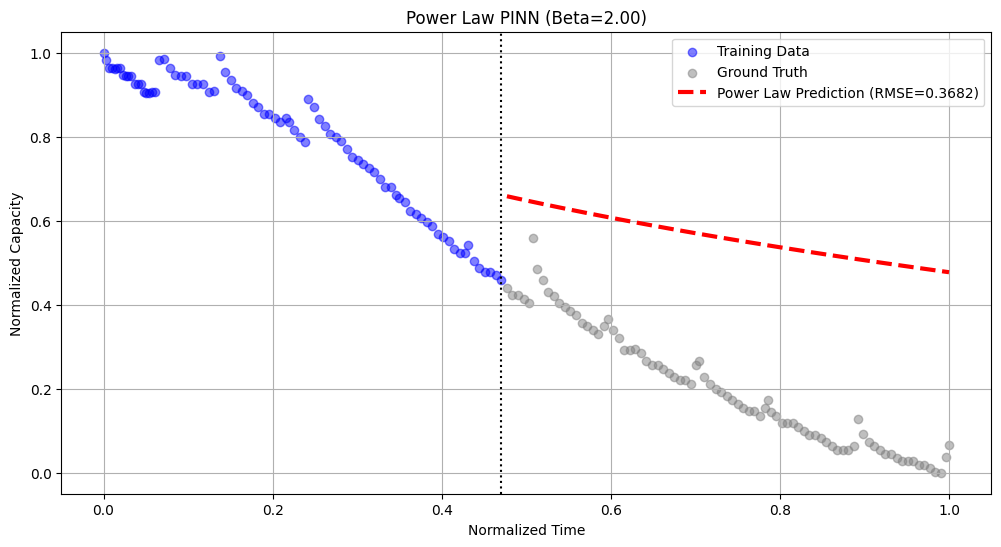

New RMSE: 0.3682


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions
C_pred_power = pinn.predict(t_test_tf)
rmse = np.sqrt(np.mean((c_test_tf.numpy() - C_pred_power)**2))

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(t_train_tf, c_train_tf, color='blue', alpha=0.5, label='Training Data')
plt.scatter(t_test_tf, c_test_tf, color='gray', alpha=0.5, label='Ground Truth')
plt.plot(t_test_tf, C_pred_power, 'r--', linewidth=3, label=f'Power Law Prediction (RMSE={rmse:.4f})')

plt.axvline(x=t_train_tf[-1], color='black', linestyle=':')
plt.title(f'Power Law PINN (Beta={pinn.beta.numpy():.2f})')
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.grid(True)
plt.show()

print(f"New RMSE: {rmse:.4f}")

 The Math (Differential Equation): Square Root Model

$$
\frac{dC}{dt} = -\alpha /(2\sqrt t)
$$
or
$$
\frac{dC}{dt} + \alpha /(2\sqrt t) = 0
$$


Where:
- $C(t)$: The current capacity (the size of the bucket right now)
- $\frac{dC}{dt}$: The rate of change (how fast the capacity is dropping)
- $\alpha$: The decay rate (positive constant; the minus sign indicates decay)

In [ ]:
class PINNModel(tf.keras.Model):
  def __init__(self):
    super(PINNModel, self).__init__()

    #building hidden layers
    self.hidden1=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden2=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden3=tf.keras.layers.Dense(32,activation='tanh')

    #buidling output layer
    self.out=tf.keras.layers.Dense(1,activation=None)

    #starting the initial value of \alpha as 0.01 which is to be trained
    self.alpha=tf.Variable(1.0, dtype=tf.float32, trainable=True)


  def call(self,t):
    #this func return the capacity predicted for a time

    x=self.hidden1(t)
    x=self.hidden2(x)
    x=self.hidden3(x)
    x=self.out(x)
    return x

  def physics_loss(self,t):

    with tf.GradientTape() as tape:
      tape.watch(t)
      c_pred=self.call(t) #capacity predicted

    #finding dc/dt
    dc_dt=tape.gradient(c_pred,t)

    a = tf.abs(self.alpha)

    residue=dc_dt+(a/(2*tf.sqrt(t+1e-6)))

    #finding how wrong are we from MSE
    loss_f=tf.reduce_mean(tf.square(residue))
    return loss_f

In [ ]:
#initializing model
pinn = PINNModel()

In [ ]:
#just for testing
_ = pinn(t_train_tf[:5])

In [ ]:
print(f"Power Law Model Initialized.")
print(f"Start Alpha: {pinn.alpha.numpy()}")

Power Law Model Initialized.
Start Alpha: 1.0


In [ ]:
#setting up training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

history_total=[]
history_data=[]
history_physics=[]

print("Starting Training( Sqrt Model )...")

epochs=4000
for epochs in range(epochs):
  with tf.GradientTape() as tape:
    c_pred=pinn(t_train_tf)
    #prediction-real data
    loss_data=tf.reduce_mean(tf.square(c_pred-c_train_tf))

    #did the obey the physics equation
    loss_physics=pinn.physics_loss(t_train_tf)

    #total loss
    total_loss=loss_data + 1.0*loss_physics

  # 3. Update Weights (Backpropagation)
  gradients = tape.gradient(total_loss, pinn.trainable_variables)
  optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

  # Store history
  history_total.append(total_loss.numpy())
  history_data.append(loss_data.numpy())
  history_physics.append(loss_physics.numpy())

  # Print progress every 500 epochs
  if epochs % 500 == 0:
        print(f"Epoch {epochs}: Loss={total_loss.numpy():.5f} | Alpha={pinn.alpha.numpy():.4f}")

print("Training Complete.")
print(f"Final Alpha: {pinn.alpha.numpy():.4f}")

Starting Training( Sqrt Model )...
Epoch 0: Loss=2976.52808 | Alpha=1.0000
Epoch 500: Loss=5.31381 | Alpha=1.0000
Epoch 1000: Loss=0.75013 | Alpha=1.0000
Epoch 1500: Loss=0.73478 | Alpha=1.0000
Epoch 2000: Loss=0.66306 | Alpha=1.0000
Epoch 2500: Loss=0.55981 | Alpha=1.0000
Epoch 3000: Loss=0.14096 | Alpha=1.0000
Epoch 3500: Loss=0.10037 | Alpha=1.0000
Training Complete.
Final Alpha: 1.0000


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


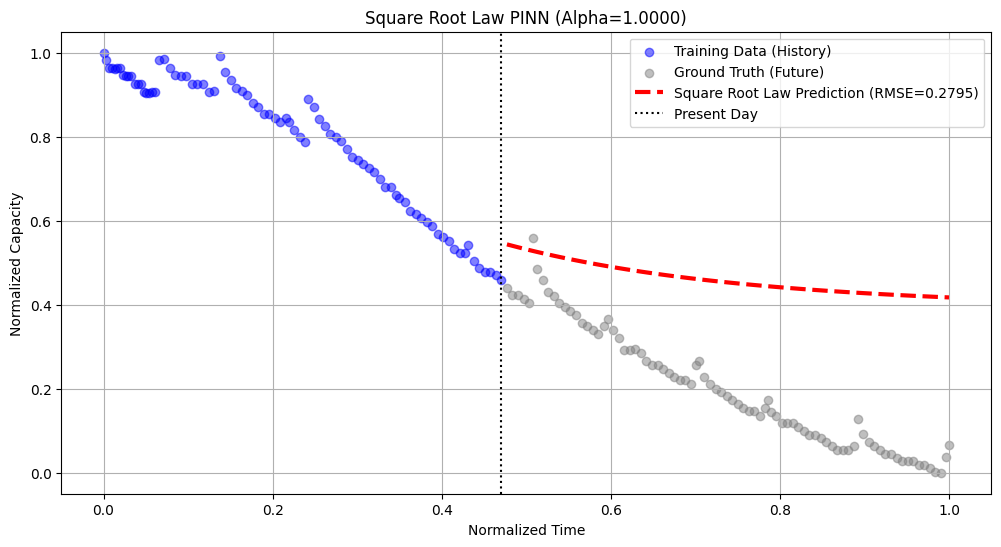

New RMSE: 0.2795


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#prediction
C_pred_sqrt = pinn.predict(t_test_tf)

#rmse
rmse = np.sqrt(np.mean((c_test_tf.numpy() - C_pred_sqrt)**2))

#Plot
plt.figure(figsize=(12, 6))
plt.scatter(t_train_tf, c_train_tf, color='blue', alpha=0.5, label='Training Data (History)')
plt.scatter(t_test_tf, c_test_tf, color='gray', alpha=0.5, label='Ground Truth (Future)')
plt.plot(t_test_tf, C_pred_sqrt, 'r--', linewidth=3, label=f'Square Root Law Prediction (RMSE={rmse:.4f})')

plt.axvline(x=t_train_tf[-1], color='black', linestyle=':', label='Present Day')
plt.title(f'Square Root Law PINN (Alpha={pinn.alpha.numpy():.4f})')
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.grid(True)
plt.show()

print(f"New RMSE: {rmse:.4f}")

 The Math (Differential Equation): Arrhenius Model

$$
\frac{dC}{dt} = - \left( A \cdot e^{\frac{-E_a}{R \cdot T}} \right) \cdot C(t)
$$
or
$$
\frac{dC}{dt} + \left( A \cdot e^{\frac{-E_a}{R \cdot T}} \right) \cdot C(t) = 0
$$


Where:
* $C(t)$: The current capacity (State of Health).
* $T$: The temperature at that specific cycle.
* $A$: The **Pre-exponential Factor** (A learnable parameter representing the frequency of chemical reactions).
* $E_a$: The **Activation Energy** (A learnable parameter representing the energy barrier).
* $R$: The Universal Gas Constant (often absorbed into $E_a$ in simplified deep learning models).

Successfully loaded 168 discharge cycles.
   Cycle  Capacity  Temperature
0      2  1.856487    32.572328
1      4  1.846327    32.725235
2      6  1.835349    32.642862
3      8  1.835263    32.514876
4     10  1.834646    32.382349


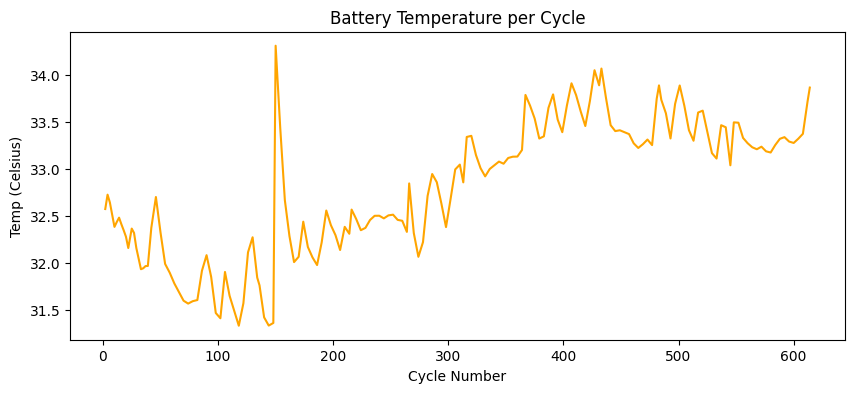

In [ ]:
# we need to extract the temperature along with the df
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_nasa_data_with_temp(mat_file_path):
    data = scipy.io.loadmat(mat_file_path)
    filename = mat_file_path.split('/')[-1].split('.')[0]
    batch = data[filename]
    cycles = batch[0][0]['cycle'][0]

    cycle_numbers = []
    capacities = []
    temperatures = []

    for i, cycle in enumerate(cycles):
        if cycle['type'][0] == 'discharge':
            try:
                capacity = cycle['data'][0][0]['Capacity'][0][0]
                temp_list = cycle['data'][0][0]['Temperature_measured'][0]
                avg_temp = np.mean(temp_list)

                cycle_numbers.append(i + 1)
                capacities.append(capacity)
                temperatures.append(avg_temp)

            except:
                pass

    df = pd.DataFrame({
        'Cycle': cycle_numbers,
        'Capacity': capacities,
        'Temperature': temperatures
    })
    return df

filename = '/content/drive/MyDrive/PINN for EV Battery Prognostics/B0005.mat'

try:
    df_battery = load_nasa_data_with_temp(filename)

    print(f"Successfully loaded {len(df_battery)} discharge cycles.")
    print(df_battery.head())

    # --- PLOT TO VERIFY ---
    plt.figure(figsize=(10,4))
    plt.plot(df_battery['Cycle'], df_battery['Temperature'], 'orange')
    plt.title("Battery Temperature per Cycle")
    plt.ylabel("Temp (Celsius)")
    plt.xlabel("Cycle Number")
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find {filename}. Please download the dataset and place it in this folder.")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_cycle = MinMaxScaler()
scaler_cap = MinMaxScaler()
scaler_temp = MinMaxScaler()

In [ ]:
df_battery['Cycle_Norm'] = scaler_cycle.fit_transform(df_battery[['Cycle']])
df_battery['Capacity_Norm'] = scaler_cap.fit_transform(df_battery[['Capacity']])
df_battery['Temperature_Norm'] = scaler_temp.fit_transform(df_battery[['Temperature']])

In [ ]:
train_len = int(len(df_battery) * 0.5)
train_data = df_battery.iloc[:train_len]
test_data = df_battery.iloc[train_len:]

In [ ]:
import tensorflow as tf

# Training Data
t_train_in = np.column_stack((train_data['Cycle_Norm'], train_data['Temperature_Norm']))
C_train_in = train_data['Capacity_Norm'].values.reshape(-1, 1)

# Testing Data
t_test_in = np.column_stack((test_data['Cycle_Norm'], test_data['Temperature_Norm']))
C_test_in = test_data['Capacity_Norm'].values.reshape(-1, 1)

In [ ]:
# Convert to Tensors
train_inputs_tf = tf.convert_to_tensor(t_train_in, dtype=tf.float32)
C_train_tf = tf.convert_to_tensor(C_train_in, dtype=tf.float32)

test_inputs_tf = tf.convert_to_tensor(t_test_in, dtype=tf.float32)
C_test_tf = tf.convert_to_tensor(C_test_in, dtype=tf.float32)

print("Input Shape:", train_inputs_tf.shape)

Input Shape: (84, 2)


In [ ]:
import tensorflow as tf

class PINNModel(tf.keras.Model):
  def __init__(self):
    super(PINNModel, self).__init__()

    self.hidden1 = tf.keras.layers.Dense(32, activation='tanh')
    self.hidden2 = tf.keras.layers.Dense(32, activation='tanh')
    self.out=tf.keras.layers.Dense(1,activation=None)

    self.A=tf.Variable(1.0,dtype=tf.float32,trainable=True)
    self.Ea=tf.Variable(1.0,dtype=tf.float32,trainable=True)

  def call(self,inputs): #input=[time,temperature]
    x=self.hidden1(inputs)
    x=self.hidden2(x)
    x=self.out(x)
    return x

  def physics_loss(self,inputs):
    t=inputs[:,0:1]
    temp=inputs[:,1:2]

    with tf.GradientTape() as tape:
      tape.watch(t)
      inputs_watched=tf.concat([t,temp],axis=1)
      c_pred=self.call(inputs_watched)

    dc_dt=tape.gradient(c_pred,t)

    #kelvin conversion
    temp_kelvin=temp*(317.15-297.15)+297.15

    #ignoring the constants R for simplify learning
    residue=dc_dt + tf.abs(self.A) * tf.exp(-tf.abs(self.Ea)/temp_kelvin) * c_pred
    return tf.reduce_mean(tf.square(residue))

In [ ]:
pinn_temp=PINNModel()

In [ ]:
_=pinn_temp(train_inputs_tf[:5])

In [ ]:
#setting up training
# 1. Setup Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

print("Starting Arrhenius Training...")
for epoch in range(5000):
    with tf.GradientTape() as tape:
        C_pred = pinn_temp(train_inputs_tf)
        loss_data = tf.reduce_mean(tf.square(C_pred - C_train_tf))

        loss_physics = pinn_temp.physics_loss(train_inputs_tf)

        total_loss = loss_data + (1.0 * loss_physics)

    # Backpropagation
    gradients = tape.gradient(total_loss, pinn_temp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn_temp.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.5f} | A={pinn_temp.A.numpy():.4f} | Ea={pinn_temp.Ea.numpy():.4f}")

print("Training Complete.")
print(f"Final Pre-Exponential Factor (A): {pinn_temp.A.numpy():.4f}")
print(f"Final Activation Energy (Ea): {pinn_temp.Ea.numpy():.4f}")

Starting Arrhenius Training...
Epoch 0: Loss=0.65018 | A=1.0000 | Ea=1.0000
Epoch 500: Loss=0.00413 | A=1.0000 | Ea=1.0000
Epoch 1000: Loss=0.00371 | A=1.0000 | Ea=1.0000
Epoch 1500: Loss=0.00353 | A=1.0000 | Ea=1.0000
Epoch 2000: Loss=0.00350 | A=1.0000 | Ea=1.0000
Epoch 2500: Loss=0.00347 | A=1.0000 | Ea=1.0000
Epoch 3000: Loss=0.00344 | A=1.0000 | Ea=1.0000
Epoch 3500: Loss=0.00342 | A=1.0000 | Ea=1.0000
Epoch 4000: Loss=0.00340 | A=1.0000 | Ea=1.0000
Epoch 4500: Loss=0.00337 | A=1.0000 | Ea=1.0000
Training Complete.
Final Pre-Exponential Factor (A): 1.0000
Final Activation Energy (Ea): 1.0000


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


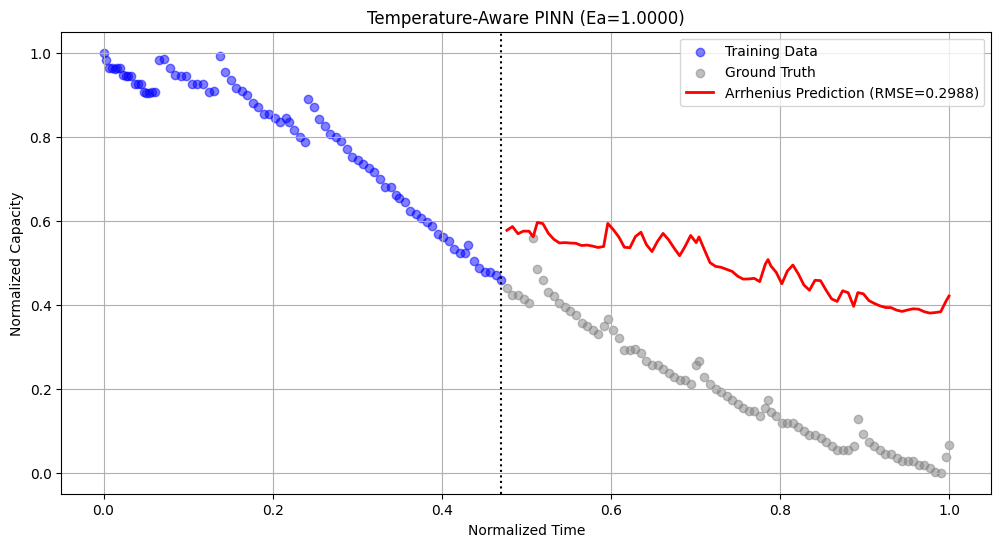

Arrhenius RMSE: 0.2988


In [ ]:
import matplotlib.pyplot as plt

C_pred_arrhenius = pinn_temp.predict(test_inputs_tf)
rmse_arrhenius = np.sqrt(np.mean((C_test_tf.numpy() - C_pred_arrhenius)**2))

plt.figure(figsize=(12, 6))
plt.scatter(t_train_in[:, 0], C_train_tf, color='blue', alpha=0.5, label='Training Data')
plt.scatter(t_test_in[:, 0], C_test_tf, color='gray', alpha=0.5, label='Ground Truth')

plt.plot(t_test_in[:, 0], C_pred_arrhenius, 'r-', linewidth=2, label=f'Arrhenius Prediction (RMSE={rmse_arrhenius:.4f})')

plt.axvline(x=t_train_in[-1, 0], color='black', linestyle=':')
plt.title(f'Temperature-Aware PINN (Ea={pinn_temp.Ea.numpy():.4f})')
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.grid(True)
plt.show()

print(f"Arrhenius RMSE: {rmse_arrhenius:.4f}")

### **The Math (Differential Equation): Verhulst (Logistic) Model**

This model accounts for saturation effects, creating an **S-Curve** shape. It assumes the degradation rate accelerates as the battery approaches its minimum viable capacity.

$$
\frac{dC}{dt} = -\alpha \cdot C(t) \cdot \left( 1 - \frac{C(t)}{C_{max}} \right)
$$

**The Residual (for the Loss Function):**
This is the equation we force to equal zero in the code:

$$
\frac{dC}{dt} + \alpha \cdot C(t) \cdot \left( 1 - \frac{C(t)}{C_{max}} \right) = 0
$$

**Where:**
* $C(t)$: The current capacity.
* $\frac{dC}{dt}$: The rate of change.
* $\alpha$: The intrinsic growth/decay rate.
* $C_{max}$: The carrying capacity (often normalized to 1.0 or learned).
* **Note:** This equation forces the rate of change to be small when $C \approx 1$ (beginning of life) and small when $C \approx 0$ (end of life), with maximum speed in the middle.

In [ ]:
class PINNModel(tf.keras.Model):
  def __init__(self):
    super(PINNModel, self).__init__()

    #building hidden layers
    self.hidden1=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden2=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden3=tf.keras.layers.Dense(32,activation='tanh')

    #buidling output layer
    self.out=tf.keras.layers.Dense(1,activation=None)

    #starting the initial value of \alpha as 0.01 which is to be trained
    self.alpha=tf.Variable(1.0, dtype=tf.float32, trainable=True)


  def call(self,t):
    #this func return the capacity predicted for a time

    x=self.hidden1(t)
    x=self.hidden2(x)
    x=self.hidden3(x)
    x=self.out(x)
    return x

  def physics_loss(self,t):

    with tf.GradientTape() as tape:
      tape.watch(t)
      c_pred=self.call(t) #capacity predicted

    #finding dc/dt
    dc_dt=tape.gradient(c_pred,t)

    a = tf.abs(self.alpha)

    residue=dc_dt+(a*c_pred*(1.0-c_pred))

    #finding how wrong are we from MSE
    loss_f=tf.reduce_mean(tf.square(residue))
    return loss_f

In [ ]:
#initializing model
pinn = PINNModel()

In [ ]:
#just for testing
_ = pinn(t_train_tf[:5])

In [ ]:
print(f"Power Law Model Initialized.")
print(f"Start Alpha: {pinn.alpha.numpy()}")

Power Law Model Initialized.
Start Alpha: 1.0


In [ ]:
#setting up training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

history_total=[]
history_data=[]
history_physics=[]

print("Starting Training...")

epochs=4000
for epochs in range(epochs):
  with tf.GradientTape() as tape:
    c_pred=pinn(t_train_tf)
    #prediction-real data
    loss_data=tf.reduce_mean(tf.square(c_pred-c_train_tf))

    #did the obey the physics equation
    loss_physics=pinn.physics_loss(t_train_tf)

    #total loss
    total_loss=loss_data + 1.0*loss_physics

  # 3. Update Weights (Backpropagation)
  gradients = tape.gradient(total_loss, pinn.trainable_variables)
  optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

  # Store history
  history_total.append(total_loss.numpy())
  history_data.append(loss_data.numpy())
  history_physics.append(loss_physics.numpy())

  # Print progress every 500 epochs
  if epochs % 500 == 0:
        print(f"Epoch {epochs}: Loss={total_loss.numpy():.5f} | Alpha={pinn.alpha.numpy():.4f}")

print("Training Complete.")
print(f"Final Alpha: {pinn.alpha.numpy():.4f}")


Starting Training...
Epoch 0: Loss=0.95485 | Alpha=1.0000
Epoch 500: Loss=0.01867 | Alpha=1.0000
Epoch 1000: Loss=0.01864 | Alpha=1.0000
Epoch 1500: Loss=0.01860 | Alpha=1.0000
Epoch 2000: Loss=0.01860 | Alpha=1.0000
Epoch 2500: Loss=0.01861 | Alpha=1.0000
Epoch 3000: Loss=0.01860 | Alpha=1.0000
Epoch 3500: Loss=0.01860 | Alpha=1.0000
Training Complete.
Final Alpha: 1.0000


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


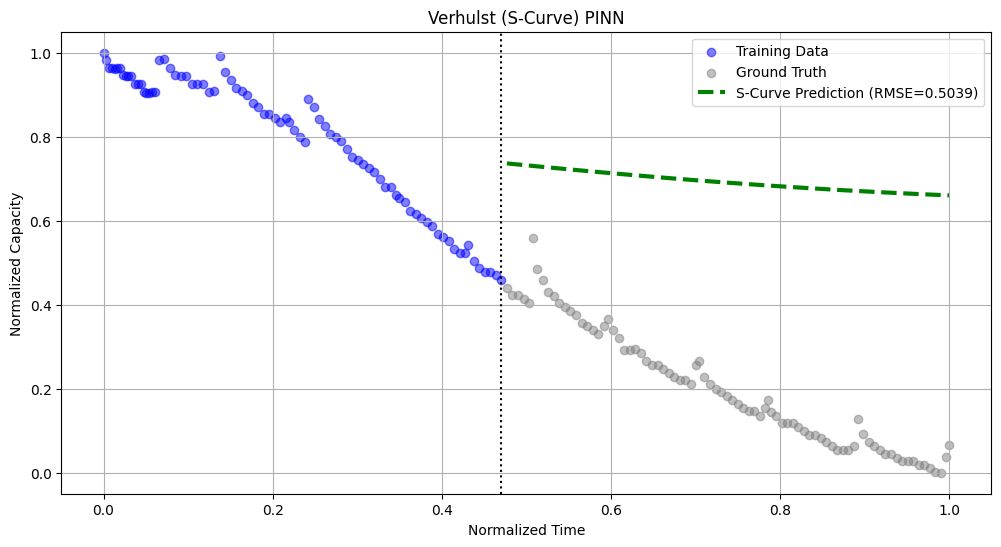

S-Curve RMSE: 0.5039


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions
C_pred_s = pinn.predict(t_test_tf)
rmse = np.sqrt(np.mean((c_test_tf.numpy() - C_pred_s)**2))

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(t_train_tf, c_train_tf, color='blue', alpha=0.5, label='Training Data')
plt.scatter(t_test_tf, c_test_tf, color='gray', alpha=0.5, label='Ground Truth')
plt.plot(t_test_tf, C_pred_s, 'g--', linewidth=3, label=f'S-Curve Prediction (RMSE={rmse:.4f})')

plt.axvline(x=t_train_tf[-1], color='black', linestyle=':')
plt.title(f'Verhulst (S-Curve) PINN')
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.grid(True)
plt.show()

print(f"S-Curve RMSE: {rmse:.4f}")